In [8]:
#from noise_analysis import *
from noise_properties_plotting import *
%matplotlib inline
from generate_timeseries import *

import time

import matplotlib

np.random.seed(int(time.time()))

import os

def cm2inch(value):
    return value/2.54;

In [11]:
from elife_settings import set_elife_settings, ELIFE

set_elife_settings()

In [3]:
# load experimental data

idx = 0

expdata = pd.read_csv('../../Data/Arumugam/MetaHIT_85IlluminaSamples.genus.csv', index_col=0)
index = expdata.index[1:]
expdata = expdata.values 
expdata = expdata[1:, :] # first row is rest of undefined species

expdata = expdata / np.sum(expdata, axis=0, keepdims=True)

experimental_abundance = np.sort(expdata[:,0])[::-1]

In [4]:
def noise_color_characteristics(ts, steadystate):
    tsvals = ts.loc[:,[col.startswith('species') for col in ts.columns]].values
    if True or np.all(np.max(np.abs(np.mean(tsvals, axis=0) - steadystate)) < 0.5 * steadystate):
        means = np.mean(tsvals, axis=0)
        stds = np.std(tsvals, axis=0)

        KL = KullbackLeibler(ts)

        ns = noise_slope(ts)

        color = ns['slope_linear'].values
    else:
        means = stds = KL = color  = np.nan
    return means, stds, KL, color
    
def mean_noise_color_abundance_equal_abundances(func, steadystates):
    # makes mean of noise color for timeseries generated with func for all sizes in steadystates 
    Nsize = len(steadystates)

    for i, size in enumerate(steadystates):
        steadystate = np.full([50,1], size)
        
        tss = func(steadystate)
        
        if i == 0:
            Nnoise = len(tss)
            
            means = np.zeros([Nnoise, Nsize]) * np.nan
            stds = np.zeros([Nnoise, Nsize]) * np.nan
            KL = np.zeros([Nnoise, Nsize]) * np.nan
            mean_color = np.zeros([Nnoise, Nsize]) * np.nan
            std_color = np.zeros([Nnoise, Nsize]) * np.nan

        for j, ts in enumerate(tss):
            means_i, stds_i, KL[j][i], color = noise_color_characteristics(ts, steadystate)
            means[j][i] = np.mean(means_i)
            stds[j][i] = np.mean(stds_i)
            mean_color[j][i] = np.mean(color)
            std_color[j][i] = np.std(color)
            
    d = [None for i in range(Nnoise)]
    
    for i in range(Nnoise):
        d[i] = pd.DataFrame(np.vstack((means[i], stds[i], KL[i], mean_color[i], std_color[i])),
                         index=['means', 'stds', 'KL', 'mean_color', 'std_color'], columns=['%.3E' % i for i in sizes])
    return d

def mean_noise_color_abundance_different_abundances(func, steadystate):
    Nsim = 3 #20
      
    Nsize = len(steadystate)
    
    for i in range(Nsim):
        tss = func(steadystate)
        
        if i == 0:
            Nnoise = len(tss)
            
            means = np.zeros([Nnoise, Nsim, Nsize]) * np.nan
            stds = np.full(means.shape, np.nan)
            KL = np.full(means.shape, np.nan)
            color = np.full(means.shape, np.nan)
        
        for j, ts in enumerate(tss):
            means[j][i], stds[j][i], KL[j][i], color[j][i] = noise_color_characteristics(ts, steadystate)
                
    means = np.mean(means, axis=1)
    stds = np.mean(stds, axis=1)
    mean_color = np.mean(color, axis=1)
    std_color = np.std(color, axis=1)
    
    d = [None for i in range(Nnoise)]

    for i in range(Nnoise):
        d[i] = pd.DataFrame(np.vstack((means[i], stds[i], mean_color[i], std_color[i])),
                      index = ['means', 'stds', 'mean_color', 'std_color'], 
                      columns = ['%.3E' % i for i in powerlawabundances])
    return d

# Different implementations

/Users/wkits/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((50, 1), 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/Users/wkits/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Compare Langevin implementations linear and sqrt


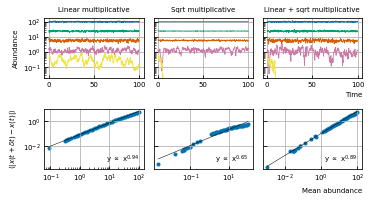

Compare different linear implementations Langevin, Ricker and Arato


/Users/wkits/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


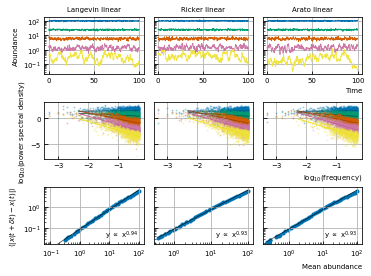

In [12]:
new = False

N = 50

steadystate = np.logspace(-0.5,2,N).reshape([N,1]) # np.random.uniform(0,10,[N,1])

params = make_params(steadystate, interaction=0.01, 
                    noise=5e-1)

path = 'study_with_interaction/'

files_ts_impl = [ path +'timeseries_' + impl + '_interaction.csv' for impl in 
                 ['Langevin_linear', 'Langevin_sqrt', 'Langevin_linear_sqrt', 
                 'Langevin_constant', 'Ricker_linear', 'Arato_linear'] 
                ]

implementations = [
          NOISE.LANGEVIN_LINEAR, NOISE.LANGEVIN_SQRT, NOISE.LANGEVIN_LINEAR_SQRT, NOISE.LANGEVIN_CONSTANT,  
        NOISE.RICKER_LINEAR, NOISE.ARATO_LINEAR
        ]

def create_new_timeseries_Langevin_diffimplementations(implementations):
    timeseries = [None for i in range(len(implementations))]
    
    for i, implementation in enumerate(implementations):
        timeseries[i] = Timeseries(params, noise_implementation = implementation, 
                            dt = 0.01, tskip=4, T=100.0).timeseries
    return timeseries

if new:
    tss = create_new_timeseries_Langevin_diffimplementations(implementations)
    
    for f, ts in zip(files_ts_impl, tss):
        if os.path.exists(f):
            os.remove(f)
        ts.to_csv(f, index=False)

titles = ['Linear multiplicative', 'Sqrt multiplicative', 'Linear + sqrt multiplicative'] #, 'Langevin linear + sqrt']

print("Compare Langevin implementations linear and sqrt")

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,3), tight_layout=True)

PlotTimeseriesComparison(files_ts_impl[:3], titles = titles, composition = ['ts', 'dx'], fig=fig)

fig.align_labels()
plt.savefig('figures_elife/supplemental/slope.pdf')
plt.show()

print("Compare different linear implementations Langevin, Ricker and Arato")

idces = [0, 4, 5]
titles = ['Langevin linear', 'Ricker linear',  'Arato linear']

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,4.5), tight_layout=True)

PlotTimeseriesComparison(np.array(files_ts_impl)[idces], titles = titles, composition = ['ts', 'psd', 'dx'], fig=fig)

plt.show()

# Different time lengths

In [9]:
new = False

path =  'study_with_interaction/'
files_ts_T = [path + 'timeseries_Langevin_linear_timelength%d.csv' % i for i in range(1,6)]
times = [1000.0, 500.0, 200.0, 100.0, 50.0]
labels = ['T = 1000', 'T = 500', 'T = 200', 'T = 100', 'T = 50']

def create_new_timeseries_Langevin_different_timelengths(times, steadystate):    
    timeseries = [None for i in range(len(times))]
    
    for i, time in enumerate(times):
        if time == max(times):
            params = make_params(steadystate, interaction=0.1)

            timeseries[0] = Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR,
                        dt=0.01, tskip=4, T=time).timeseries
        else:
            ts = timeseries[0].copy()
            timeseries[i] = ts.iloc[:int(len(ts)* time / times[0])]
    return timeseries

if new:
    tss = create_new_timeseries_Langevin_different_timelengths(times, np.ones([50,1]))
    for f, ts in zip(files_ts_T, tss):
        ts.to_csv(f, index=False)

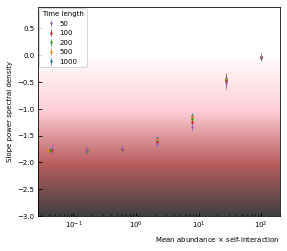

In [32]:
new = False

Nsize = 10
sizes = np.logspace(-3, 2, Nsize)

path = 'study_with_interaction/'
files_noise_T = [path + 'noisecolor_Langevin_linear_timelength%d.csv' % i for i in range(1,6)]
times = [1000.0, 500.0, 200.0, 100.0, 50.0]

labels = ['1000', '500', '200', '100', '50']

if new:
    create_new_timeseries_Langevin = partial(create_new_timeseries_Langevin_different_timelengths, times)
    d = mean_noise_color_abundance_equal_abundances(create_new_timeseries_Langevin, sizes)

    for file, df in zip(files_noise_T, d):
        df.to_csv(file)
    
PlotNoiseColorComparison(files_noise_T, legend_title='Time length', labels=labels)
#plt.savefig('figures/interaction_noisecolor_timelengths.png')
plt.show()

# Different timesteps

In [30]:
new = False

path = 'study_with_interaction/'
files_ts_fundt = [path + 'timeseries_Langevin_linear_dt%d.csv' % i for i in range(1, 5)]

tskips = [199, 99, 19, 9]

labels = ['$\delta t$ = 0.0005', '$\delta t$ = 0.001', '$\delta t$ = 0.005', '$\delta t$ = 0.01']

def create_new_timeseries_Langevin_different_dt(tskips, steadystate):
    initcond = np.random.normal(1, 0.1, [N, 1]) * np.copy(steadystate)

    T = 100.0
    
    timeseries = [None for i in range(len(tskips))]
    
    for i, tskip in enumerate(tskips):
        params = make_params(steadystate, interaction=0.1)
        
        timeseries[i] = Timeseries(params, noise_implementation=NOISE.LANGEVIN_LINEAR,
                    dt=0.1 / (tskip + 1), tskip=tskip, T=T).timeseries
    return timeseries

if new:
    tss = create_new_timeseries_Langevin_different_dt(tskips, np.ones([50,1]))
    
    for f, ts in zip(files_ts_fundt, tss):
        if os.path.exists(f):
            os.remove(f)
        ts.to_csv(f, index=False)

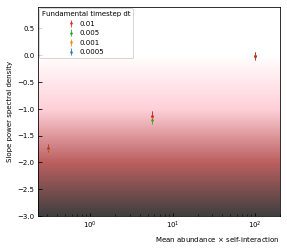

In [40]:
new = False

Nsize = 5
sizes = np.logspace(-3, 2, Nsize)

path = 'study_with_interaction/'
files_noise_fundt = [path + 'noisecolor_abundance_Langevin_dt%d.csv' % i for i in range(1,5)]
tskips = [199, 99, 19, 9]

labels = ['0.0005', '0.001', '0.005', '0.01']

if new:
    create_new_timeseries_Langevin = partial(create_new_timeseries_Langevin_different_dt, tskips)
    d = mean_noise_color_abundance_equal_abundances(create_new_timeseries_Langevin, sizes)

    for file, df in zip(files_noise_fundt, d):
        df.to_csv(file)
    
PlotNoiseColorComparison(files_noise_fundt, legend_title='Fundamental timestep dt', labels=labels)
#plt.savefig('figures/interaction_noisecolor_timelengths.png')
plt.show()

# Different interaction strengths

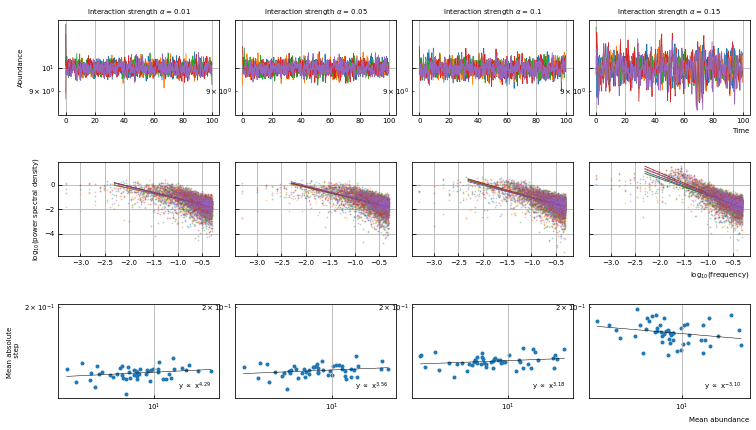

In [29]:
new = False

path = 'study_with_interaction/'
files_ts_int = [path + 'timeseries_Langevin_linear_interaction%d.csv' % i for i in [1,2,3,6]] 

interactions = [0.01, 0.05, 0.1, 0.15]

labels = [r'Interaction strength $\alpha$ = %s' % f for f in ['0.01', '0.05', '0.1', '0.15']]

def create_new_timeseries_Langevin_different_interactionstrengths(interactions, steadystate):
    timeseries = [None for i in range(len(interactions))]
    
    for i, interaction in enumerate(interactions):
        params = make_params(steadystate, interaction=interaction)
        
        timeseries[i] = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                            dt = 0.01, tskip=4, T=100.0).timeseries
    return timeseries

if new:
    tss = create_new_timeseries_Langevin_different_interactionstrengths(interactions, np.full([50,1], 10))
    
    for f, ts in zip(files_ts_int, tss):
        if os.path.exists(f):
            os.remove(f)
        ts.to_csv(f, index=False)
    
PlotTimeseriesComparison(files_ts_int, titles=labels, composition = ['ts', 'psd', 'dx'])

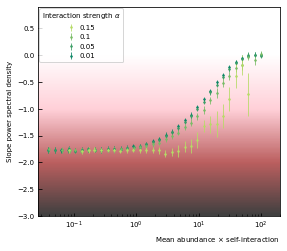

In [41]:
new = False

Nsize = 5
sizes = np.logspace(-3, 2, Nsize)

path = 'study_with_interaction/'
files_noise_int = [path + 'noisecolor_Langevin_linear_interaction%d.csv' % i for i in [1,2,3,6]]
interactions = [0.01, 0.05, 0.1, 0.15]

labels = ['0.01', '0.05', '0.1', '0.15']

if new:
    create_new_timeseries_Langevin = partial(create_new_timeseries_Langevin_different_interactionstrengths, interactions)
    d = mean_noise_color_abundance_equal_abundances(create_new_timeseries_Langevin, sizes)

    for file, df in zip(files_noise_int, d):
        df.to_csv(file)
    
PlotNoiseColorComparison(files_noise_int, legend_title=r'Interaction strength $\alpha$', 
                         labels=labels, interaction_colors=True)
#plt.savefig('figures/interaction_noisecolor_interactions.png')
plt.show()

# Dependence on growth rate?

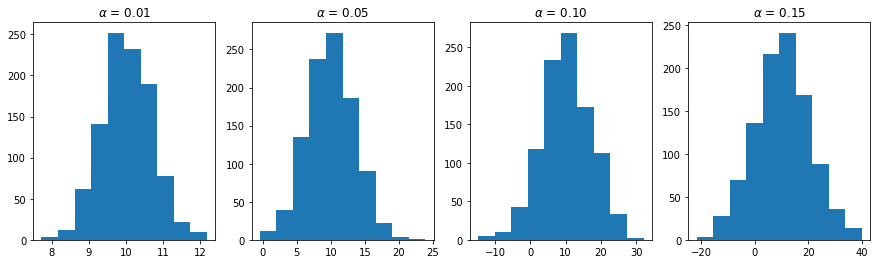

In [19]:
new = False

N = 50
size = 10.0

alphas = [0.01, 0.05, 0.1, 0.15]

steadystate = np.full([N,1], size)

fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1,len(alphas))

for i, alpha in enumerate(alphas):
    ax = fig.add_subplot(gs[i])
    ax.set_title(r'$\alpha$ = %.2f' % alpha)
    
    gg = np.zeros(0)
    
    for j in range(20):
        stable = False

        while not stable:
            # interaction
            omega = np.random.normal(0, alpha, [N, N]); np.fill_diagonal(omega, -1)

            # no immigration
            mu = np.zeros([N, 1])

            # growthrates determined by the steady state
            g = - omega.dot(steadystate).reshape([N,1])

            stable = is_stable(steadystate, omega)
        
        gg = np.append(gg, g)
        
    ax.hist(gg)

plt.show()

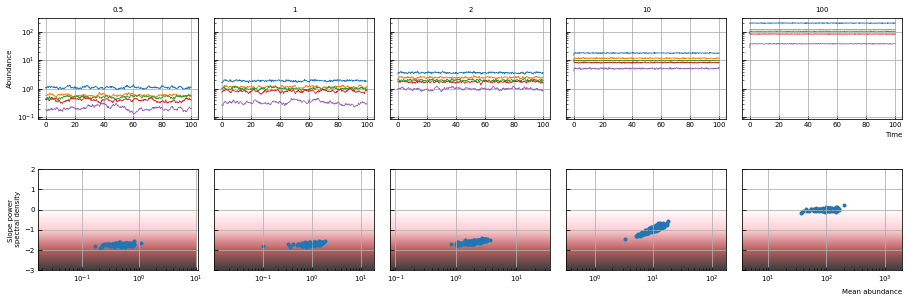

In [42]:
new = False

files_ts_growthrates = ['study_with_interaction/timeseries_Langevin_growthrate%d.csv' % i for i in range(1,6)]

growthrates = [0.5, 1, 2, 10, 100]

titles = ['0.5', '1', '2', '10', '100']

def create_new_timeseries_different_growthrates(growthrates, steadystate_prov):
    params = make_params(steadystate_prov, noise=1e-1)
    
    timseries = [None for _ in range(len(growthrates))]
    
    for i, growthrate in enumerate(growthrates):
        # different growthrates determined by the steady state
        g = np.full([N,1], growthrate)
        params['growthrate'] = g
        
        # no interaction + calculate selfinteraction
        omega = np.random.normal(0, 0.02, [N, N]); np.fill_diagonal(omega, np.random.normal(-1,0.1,N))
        params['interaction_matrix'] = omega
        
        steadystate = - np.linalg.inv(omega).dot(g)
        
        params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

        timeseries[i] = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                            dt = 0.01, tskip=4, T=100.0, seed=int(time.time())).timeseries
    return timseries

if new:
    tss = create_new_files_different_growthrates(growthrates, np.logspace(-2,1,N).reshape([150,1]))
    
    for f, ts in zip(files_ts_growthrates, tss):
        if os.path.exists(f):
            os.remove(f)
        ts.to_csv(f, index=False) 
        
PlotTimeseriesComparison(files_ts_growthrates, titles = titles, composition=['ts', 'nc'])
#plt.savefig(ffig = 'figures/no_interaction_timeseries_diffnoisesources.png')
plt.show()

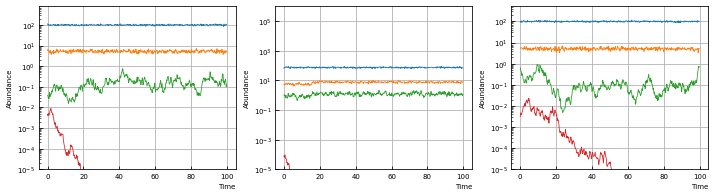

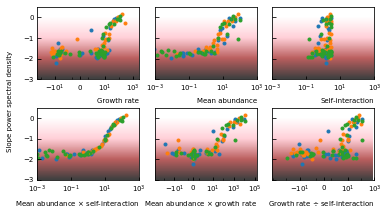

In [9]:
fig_ts = plt.figure(figsize=(12,3))

ax_ts1 = fig_ts.add_subplot(131)
ax_ts2 = fig_ts.add_subplot(132)
ax_ts3 = fig_ts.add_subplot(133)

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,3), tight_layout=True)

gs = gridspec.GridSpec(2, 3, hspace=0.4,wspace=0.15, top=0.95, left=0.1, bottom=0.15, right=0.95)
gs_tot = gridspec.GridSpec(1,1, top=0.95, left=0.05, bottom=0.08, right=0.95)

ax = fig.add_subplot(gs_tot[0], frameon=False)
ax.set_ylabel('Slope power spectral density')
ax.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)

ax_nc = fig.add_subplot(gs[0]); ax_nc2 = fig.add_subplot(gs[1]); ax_nc3 = fig.add_subplot(gs[2])
ax_nc4 = fig.add_subplot(gs[3]); ax_nc5 = fig.add_subplot(gs[4]); ax_nc6 = fig.add_subplot(gs[5])

for ax in [ax_nc, ax_nc5, ax_nc6]:
    ax.set_xscale('symlog')
for ax in [ax_nc2, ax_nc3, ax_nc4]:
    ax.set_xscale('log')
    
vmin_g = 0; vmax_g = 0; vmin_gsi = 0; vmax_gsi = 0; vmin_gma = 0; vmax_gma = 0
    
for i in range(3):
    N = 40
    
    steadystate = np.logspace(-3,2,N).reshape([N,1])
    
    selfints = np.random.uniform(0.1,3,N)
    params = make_params(steadystate, interaction=0.05, selfint=selfints, noise=0.5)
    
    params['initial_condition'] = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                        dt = 0.01, tskip=4, T=10.0, seed=int(time.time())).endpoint

    ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                        dt = 0.01, tskip=4, T=100.0, seed=int(time.time())).timeseries
        
    PlotTimeseriesComparison([ts], composition=['ts'], fig=globals()['ax_ts%d' % (i+1)])
    nc = noise_slope(ts)
    ns = nc['slope_linear']
    
    g = params['growth_rate']
    vmin_g = min(vmin_g, 10*np.min(g))
    vmax_g = max(vmax_g, 10*np.max(g))
    
    ax_nc.scatter(g, ns)
    ax_nc.errorbar(g, ns, nc['std_slope_linear'], linestyle='')
    
    ax_nc2.scatter(ts.drop('time', axis=1).mean(), ns)
    ax_nc2.errorbar(ts.drop('time', axis=1).mean(), ns, nc['std_slope_linear'], linestyle='')
    
    ax_nc3.scatter(selfints, ns)
    ax_nc3.errorbar(selfints, ns, nc['std_slope_linear'], linestyle='')

    ax_nc4.scatter(selfints * ts.drop('time', axis=1).mean(), ns)
    ax_nc4.errorbar(selfints * ts.drop('time', axis=1).mean(), ns, nc['std_slope_linear'], linestyle='')
    
    ax_nc5.scatter(g.flatten() * ts.drop('time', axis=1).mean(), ns)
    ax_nc5.errorbar(g.flatten() * ts.drop('time', axis=1).mean(), ns, nc['std_slope_linear'], linestyle='')
    
    vmin_gma = min(vmin_gma, 10*np.min(g.flatten() * ts.drop('time', axis=1).mean()))
    vmax_gma = max(vmax_gma, 10*np.max(g.flatten() * ts.drop('time', axis=1).mean()))
    
    ax_nc6.scatter(g.flatten() / selfints, ns)
    ax_nc6.errorbar(g.flatten() / selfints, ns, nc['std_slope_linear'], linestyle='')
    
    vmin_gsi = min(vmin_gsi, 10*np.min(-g.flatten() / selfints))
    vmax_gsi = max(vmax_gsi, 10*np.max(-g.flatten() / selfints))

for ax, label in zip([ax_nc, ax_nc2, ax_nc3, ax_nc4, ax_nc5, ax_nc6],
                     ['Growth rate', 'Mean abundance', 'Self-interaction', r'Mean abundance $\times$ self-interaction', 
                      r'Mean abundance $\times$ growth rate', r'Growth rate $\div$ self-interaction']):
    ax.set_xlabel(label, ha='right', x=1)

for ax, left, right in zip([ax_nc, ax_nc2, ax_nc3, ax_nc4, ax_nc5, ax_nc6],
                          [vmin_g, 1e-3, 1e-3, 1e-3, vmin_gma, vmin_gsi],
                          [vmax_g, 1e3, 1e3, 1e3, vmax_gma, vmax_gsi]):
    xx = np.linspace(0.5, -3, 500).reshape([500, 1])
    ax.imshow(xx, cmap=noise_cmap_ww, vmin=noise_lim[0], vmax=noise_lim[1], extent=(left, right, -3, 0.5),
             aspect='auto', alpha=0.75)

ax_nc.set_xticks([-10**1, 0 , 10**1, 10**3])
ax_nc5.set_xticks([-10**1, 0 , 10**1, 10**3, 10**5])
ax_nc6.set_xticks([-10**1, 0 , 10**1, 10**3])

for ax in [ax_nc2, ax_nc3, ax_nc5, ax_nc6]: #[ax_nc2, ax_nc4, ax_nc6]:
    ax.tick_params(axis='both', left=True, labelleft=False)
    
#plt.savefig('figures_elife/supplemental/interaction_noisecolor_growthrate.pdf')
plt.show()

# Different initial conditions

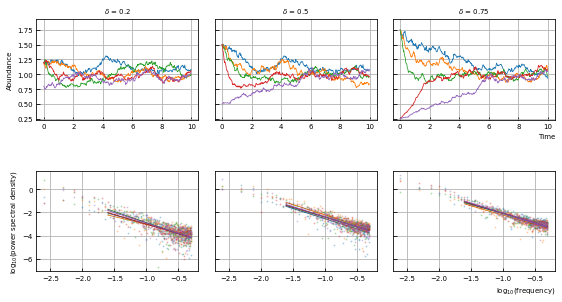

In [18]:
new = False

path = 'study_with_interaction/'
files_ts_ic = [path + 'timeseries_Langevin_linear_initcond%d.csv' % i for i in range(1, 6)]

deviations = [0.01, 0.1, 0.2, 0.5, 0.75]

labels = ['$\delta$ = 0.01', '$\delta$ = 0.1', '$\delta$ = 0.2', 
          '$\delta$ = 0.5', '$\delta$ = 0.75']

def create_new_timeseries_Langevin_different_initial_conditions(deviations, steadystate):
    timeseries = [None for _ in range(len(deviations))]
    
    params = make_params(steadystate, interaction=0.1)

    for i, deviation in enumerate(deviations):
        params['initial_condition'] = steadystate * (1 + np.random.choice([-1,1], steadystate.shape) * deviation)
        
        timeseries[i] = Timeseries(params, dt = 5e-3, T=10.0, tskip = 4,
                                    noise_implementation = NOISE.LANGEVIN_LINEAR).timeseries
    
    return timeseries

if new:
    tss = create_new_timeseries_Langevin_different_initial_conditions(deviations, np.full([50, 1], 10))
    
    for f, ts in zip(files_ts_ic, tss):
        ts.to_csv(f, index=False)
    
plot_ts = PlotTimeseriesComparison(files_ts_ic[2:], composition=['ts', 'psd'], titles=labels[2:])
plot_ts.axes['ts'][0].set_yscale('linear')
plt.show()

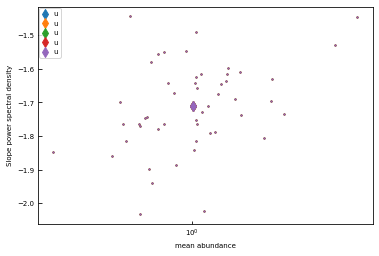

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

for f in files_ts_ic:
    x = pd.read_csv(files_ts_ic[0])
    
    ns = noise_slope(x)
    mean_ts = x.mean()
    mean_ts.drop('time', inplace=True)
    
    l = ax.plot(mean_ts, ns['slope_linear'].values,
                linestyle='', marker='.', markersize=2)
    ax.scatter(np.mean(mean_ts), np.mean(ns['slope_linear'].values), label=f[2], 
               color=l[0].get_color(), s=50, marker='d')
ax.legend()
ax.set_xlabel('mean abundance')
ax.set_ylabel('Slope power spectral density')

ax.set_xscale('log')

plt.show()

# Complex dynamics

temp/timeseries_Langevin_linear_unstable1.csv
temp/timeseries_Langevin_linear_unstable2.csv
temp/timeseries_Langevin_linear_unstable3.csv
temp/timeseries_Langevin_linear_unstable4.csv
temp/timeseries_Langevin_linear_unstable5.csv


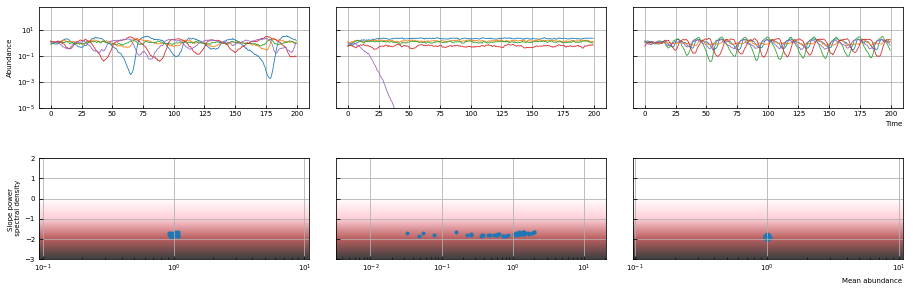

In [24]:
new = False

path = 'study_with_interaction/'
files_ts_complex = [path + 'timeseries_Langevin_linear_unstable%d.csv' % i for i in range(1,6)] 
                 
def create_new_timeseries_Langevin_complex_dynamics(steadystate):
    np.random.seed(int(time.time()))
    
    params = {}
    
    N = len(steadystate)
    
    initcond = steadystate * np.random.uniform(0.5, 1.5, steadystate.shape)
    params['initial_condition'] = initcond

    params['noise_linear'] = 1e-1

    oscillating = False

    while not oscillating:            
        # interaction
        omega = np.random.normal(0, 0.15, [N, N]); np.fill_diagonal(omega, -1)

        eigvals = np.linalg.eigvals(omega)

        if np.any(np.real(eigvals) > 0) and np.any(np.imag(eigvals[np.real(eigvals) > 0]) > 0):
            oscillating = True
        
    # growthrates determined by the steady state
    g = - omega.dot(steadystate).reshape([N,1])

    params['interaction_matrix'] = omega 
    params['growth_rate'] = g 
    params['immigration_rate'] = np.zeros(steadystate.shape)

    return Timeseries(params, f = f, dt = 1e-2, tskip = 4, T=200.0,
                noise_implementation = NOISE.LANGEVIN_LINEAR, seed=int(np.random.uniform(0,1e6))).timeseries

if new:
    for f in files_ts_complex:
        print(f)
        ts = create_new_timeseries_Langevin_complex_dynamics(np.ones([50,1]))
        ts.to_csv(f, index=False)
        
fig = plt.figure(figsize=(15,5))

PlotTimeseriesComparison(files_ts_complex[:3], composition=['ts', 'nc'], fig = fig)

plt.show()

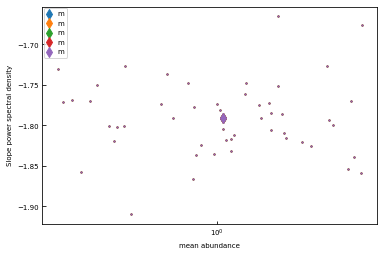

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

for f in files_ts_complex:
    x = pd.read_csv(files_ts_complex[0])
    
    ns = noise_slope(x)
    
    x.drop('time', axis='columns', inplace=True)
    
    l = ax.plot(np.mean(x.values, axis=0), ns['slope_linear'].values,
                linestyle='', marker='.', markersize=2)
    ax.scatter(np.mean(x.values), np.mean(ns['slope_linear'].values), label=f[2], 
               color=l[0].get_color(), s=50, marker='d')
ax.legend()
ax.set_xlabel('mean abundance')
ax.set_ylabel('Slope power spectral density')
ax.set_xscale('log')

plt.show()

# Experimental rank abundance curve (powerlaw)

(1e-09, 1.0)

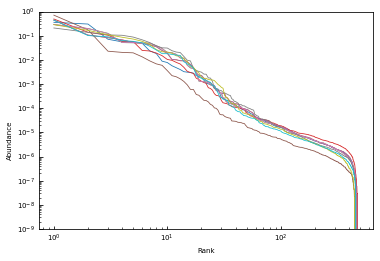

In [26]:
Nspecies = len(expdata)

# Select 10 random numbers, for showing the rank abundance distribution
selection = np.random.choice(len(expdata[0]), 10)

for i in selection:
    plt.plot(range(1,Nspecies+1), np.sort(expdata[:,i])[::-1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Abundance', ha='right', x=1)
plt.ylim([1e-9, 1e0])
#plt.savefig('experimental_rank_abundance.png')

(0.0005, 500.0)

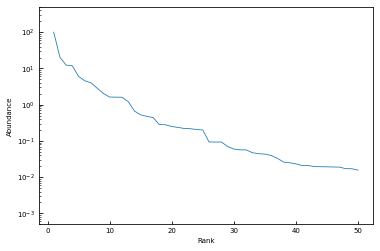

In [27]:
N = 50

powerlawabundances = np.sort(expdata[:,np.random.randint(len(expdata[0]))])[::-1][:N]

for i in range(1, len(powerlawabundances)):
    if powerlawabundances[i] == powerlawabundances[i-1] and i != len(powerlawabundances) - 1:
        powerlawabundances[i] = (powerlawabundances[i] + powerlawabundances[i+1])/2
    elif powerlawabundances[i] == powerlawabundances[i-1]:
        powerlawabundances[i] = 0.9*powerlawabundances[i]

# rescale such that max is 10**2 
powerlawabundances *= 10**2/np.max(powerlawabundances)

plt.plot(range(1,N+1), powerlawabundances)
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Abundance')
plt.ylim([5e-4, 5e2])
#plt.savefig('experimental_rank_abundance.png')

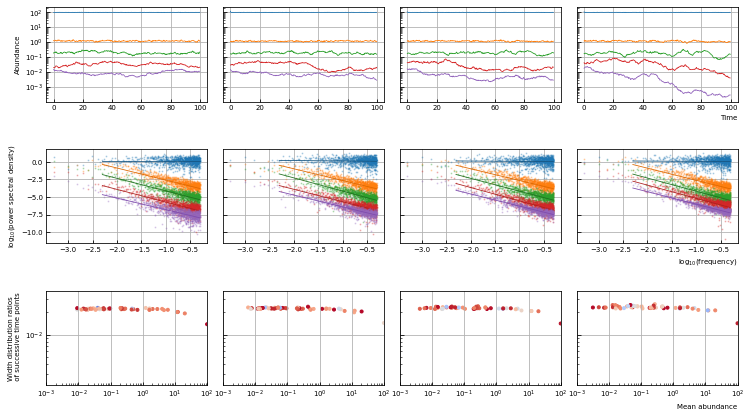

In [33]:
new = False

path = 'study_with_interaction/'
files_ts_pl = ['timeseries_Langevin_linear_powerlaw_alpha%d.csv' % i for i in range(1,5)]
                
interactions = [0, 0.1, 0.15, 0.2]

labels = [r'$\alpha$ = 0', r'$\alpha$ = 0.1', r'$\alpha$ = 0.15', r'$\alpha$ = 0.2']

if new:
    steadystate = powerlawabundances.copy().reshape([len(powerlawabundances), 1])
    
    tss = create_new_timeseries_Langevin_different_interactionstrengths(interactions, steadystate)
        
    for f, ts in zip(files_ts_pl, tss):
        if os.path.exists(f):
            os.remove(f)
        ts.to_csv(f, index=False)
            
plt_ts = PlotTimeseriesComparison(files_ts_pl, composition=['ts', 'psd', 'disdx'])
for ax in plt_ts.axes['disdx']:
    ax.set_xlim([1e-3,1e2])
plt.show()

1 0.0282187180397 0 1.00039544716
1 0.23960869438 0 1.00827050753
2 0.0283736615153 0 1.00027298383
2 0.265813916349 0 1.02801951969
3 0.0299449981964 0 1.00029507703
3 0.338994876023 0 1.1831554774
4 0.0335306911429 0 1.0003408202
4 0.47847092751 0 1.41188316955


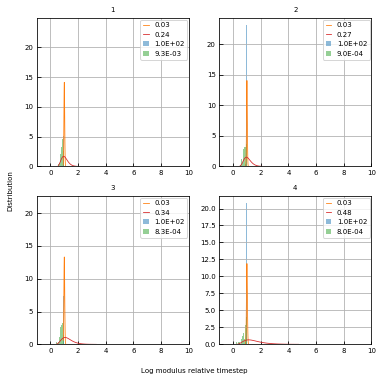

In [36]:
from scipy import stats

fig = plt.figure(figsize=(6,6), tight_layout=True)
gs = gridspec.GridSpec(2,2,wspace=0.2,hspace=0.2)
gs_tot = gridspec.GridSpec(1,1,left=0.08, bottom=0.08)

path = 'study_with_interaction/'
files_ts_pl = [path + 'timeseries_Langevin_linear_powerlaw_alpha%d.csv' % i for i in range(5,9)]
                
titles = range(1,5)

def ratio(x):
    x = x[:-1]/x[1:]
    x = x[np.isfinite(x)]
    return x

for gsi, file, title in zip(gs, files_ts_pl, titles):
    ax = fig.add_subplot(gsi)
    ax.set_title(title)
    
    df = pd.read_csv(file)
    
    # plot different mean abundances, first sort the species
    sorted_idces = df.mean().sort_values().index.tolist()[::-1]
    sorted_idces.remove('time')
    
    mean = df.mean()
        
    for i in [sorted_idces[0], sorted_idces[-1]]:
        x = df[i].values
        
        x_transf = ratio(x)
                
        a,b,c = stats.lognorm.fit(x_transf,floc=0) #Gives the paramters of the fit 
        
        print(title, a, b, c)
        
        x_fit = np.linspace(x_transf.min(),x_transf.max(),100)
        pdf_fitted = stats.lognorm.pdf(x_fit,a,b,c) #Gives the PDF
        
        ax.hist(x_transf, alpha=0.5, label='%.1E' % mean[i], normed=True, bins = np.linspace(0,1,30)) #20,41))
        ax.plot(x_fit, pdf_fitted, label='%.2f'%a)
        
    ax.set_xlim([-1,10])
    ax.legend() #loc=3)
    #ax.set_yscale('log')
    ax.grid()

ax = fig.add_subplot(gs_tot[0], frameon=False)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.set_ylabel('Distribution')
ax.set_xlabel('Log modulus relative timestep')
    
#plt.savefig('figures/experimental_timestep.png')
plt.show()

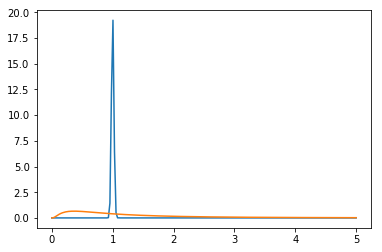

In [45]:
x_fit = np.linspace(0,5,200)

for i in [0.02,1]:
    pdf_fitted = stats.lognorm.pdf(x_fit,i,0,1) #Gives the PDF
    
    #print(pdf_fitted)
    plt.plot(x_fit, pdf_fitted)


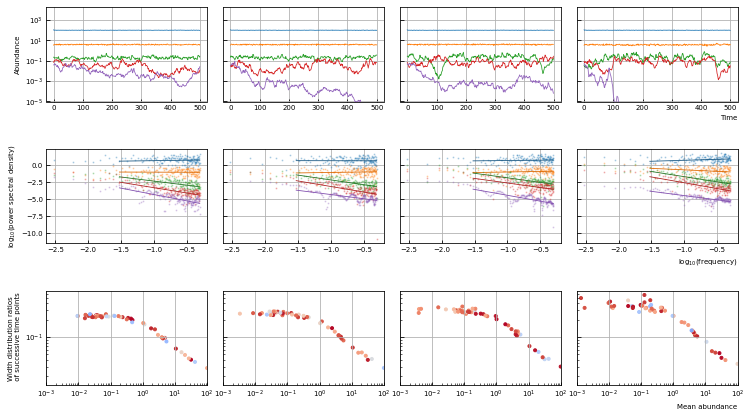

In [39]:
# again with more noise and bigger timestep
# create_new_timeseries_Langevin_different_interactionstrengths with noise = 0.2 and dt=0.01, tskip=149, T=500

path = 'study_with_interaction/'
files_ts_pl = [path + 'timeseries_Langevin_linear_powerlaw_alpha%d.csv' % i for i in range(5,9)]

interactions = [0, 0.1, 0.15, 0.2]

titles = [r'$\alpha$ = 0', r'$\alpha$ = 0.1', r'$\alpha$ = 0.15', r'$\alpha$ = 0.2']

plt_ts = PlotTimeseriesComparison(files_ts_pl, composition=['ts', 'psd', 'disdx'])
for ax in plt_ts.axes['disdx']:
    ax.set_xlim([1e-3,1e2])
plt.show()

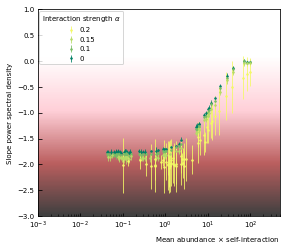

In [60]:
new = False

path = 'study_with_interaction/'
files_noise_pl = [path + 'noisecolor_Langevin_linear_powerlaw_sigma%d.csv' % i for i in range(1,5)]
interactions = [0, 0.1, 0.15, 0.2]

labels = ['0', '0.1', '0.15', '0.2']

if new:
    create_new_timeseries_Langevin = partial(create_new_timeseries_Langevin_different_interactionstrengths, interactions)
    steadystate = powerlawabundances.copy().reshape([len(powerlawabundances),1])
    d = mean_noise_color_abundance_different_abundances(create_new_timeseries_Langevin, steadystate)

    for file, df in zip(files_noise_pl, d):
        df.to_csv(file)
    
plt_nc = PlotNoiseColorComparison(files_noise_pl, legend_title=r'Interaction strength $\alpha$', 
                         labels=labels, interaction_colors=True)
plt_nc.set_limits([1e-3,5e2, -3, 1])
#plt.savefig('figures/interaction_noisecolor_interactions.png')
plt.show()

# Summary interaction

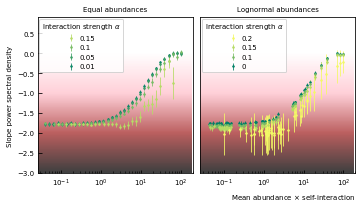

In [14]:
#fig = plt.figure(figsize=(7,3), tight_layout=True)
fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,3), tight_layout=True)

gs = gridspec.GridSpec(1,2, top=0.9, bottom=0.18, left=0.1, right=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[0])
ax.set_title('Equal abundances')

path = 'study_with_interaction/'
files_noise_int = [path + 'noisecolor_Langevin_linear_interaction%d.csv' % i for i in [1,2,3,6]]

labels = ['0.01', '0.05', '0.1', '0.15']

PlotNoiseColorComparison(files_noise_int, labels=labels, ax = ax,
                         legend_title=r'Interaction strength $\alpha$', interaction_colors=True)

ax.set_xlabel('')

ax = fig.add_subplot(gs[1], sharex=ax, sharey=ax)
ax.set_title('Lognormal abundances')

path = 'study_with_interaction/'
files_noise_pl = [path + 'noisecolor_Langevin_linear_powerlaw_sigma%d.csv' % i for i in range(1,5)]

labels = ['0', '0.1', '0.15', '0.2']

PlotNoiseColorComparison(files_noise_pl, labels=labels, ax=ax,
                          legend_title=r'Interaction strength $\alpha$', interaction_colors=True)
ax.tick_params(axis="both", labelleft=False, left=False)
ax.set_ylabel('')

#plt.savefig('figures/interaction_noisecolor_summary.pdf')
#plt.savefig('figures/presentationSophie/interaction_noisecolor_summary.pdf')
plt.show()

In [72]:
def plot_timeseries_parameters(ts, params, var='growth_rate'):
    fig = plt.figure(figsize=(12,4))

    gs = gridspec.GridSpec(2,3,wspace=0.3) #, height_ratios=[3,1])
    ax_ra = fig.add_subplot(gs[0,0])
    ax_ts = fig.add_subplot(gs[:,1])
    ax_pws = fig.add_subplot(gs[:,2])
    ax_r = fig.add_subplot(gs[1,0])

    ax_ts.set_yscale('log')
    ax_ts.set_ylabel('Abundance')
    ax_ts.set_xlabel('Time')

    ax_ra.plot(range(1,N+1), ts.values[:,1:].mean(axis=0))
    ax_ra.set_yscale('log')
    #ax_ra.set_xlabel('Rank')
    ax_ra.set_ylabel('Abundance')
    ax_ra.set_ylim([5e-4, 5e2])
    
    if var == 'growth_rate':
        ax_r.plot(range(1,N+1), params['growth_rate'])
        ax_r.set_xlabel('Rank') 
        ax_r.set_ylabel('Growth rate')
        ax_r.axhline(y=0)
    elif var == 'selfint':
        ax_r.plot(range(1,N+1), np.diag(params['interaction_matrix']))
        ax_r.set_xlabel('Rank') 
        ax_r.set_ylabel('Self-interaction')
        ax_r.axhline(y=0)

    for j in range(1, N+1, int(N/5)):
        ax_ts.plot(ts['time'][::10], ts['species_%d'%j][::10])

        example_noise_fit(ax_pws, ts['species_%d'%j])
    #plt.savefig('figures/powerlaw_timeseries.png')

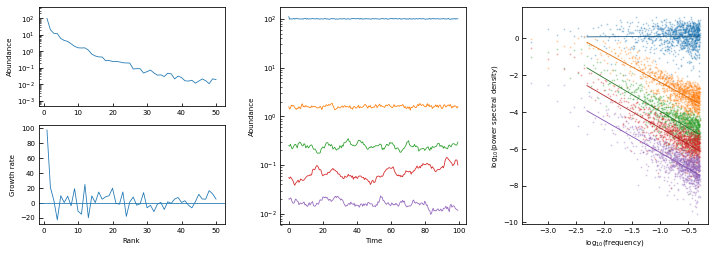

In [64]:
N = 50

steadystate = powerlawabundances[:N].reshape([N,1])

params = make_params(steadystate, interaction=0.1)

ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR,
                    dt=0.01, tskip=4, T=100.0).timeseries

plot_timeseries_parameters(ts, params)

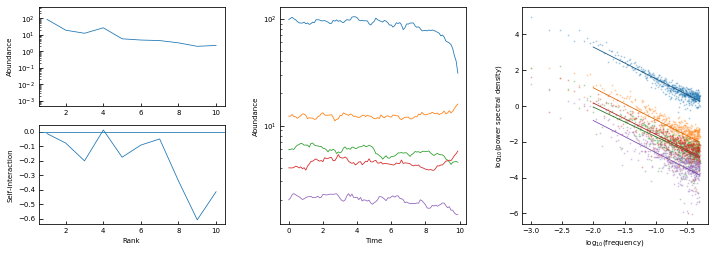

In [68]:
N = 10

steadystate = powerlawabundances[:N].reshape([N,1])

params = {}

params['immigration_rate'] = np.zeros([N, 1])

omega = np.random.normal(0,0.01,[N, N]); # np.zeros([N,N]);
np.fill_diagonal(omega, 0)

g = np.random.uniform(0.5,2,[N,1])
params['growth_rate'] = g

# diagonal terms determined by the steady state
diag = - ((g + omega.dot(steadystate))/steadystate)
np.fill_diagonal(omega, diag)
params['interaction_matrix'] = omega
params['noise_linear'] = 1e-1
params['initial_condition'] = steadystate * np.random.normal(1, 0.01, steadystate.shape)

ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR,
                    dt=1e-2, tskip=0, T=10.0).timeseries

plot_timeseries_parameters(ts, params, var='selfint')

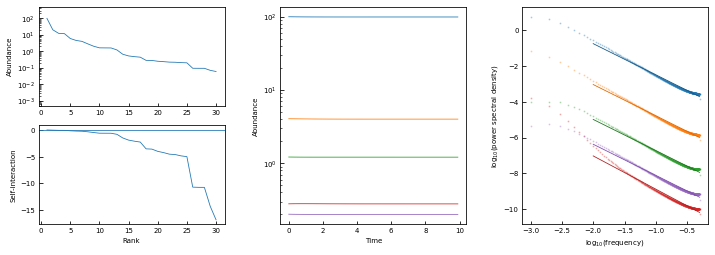

In [69]:
N = 30

steadystate = powerlawabundances[:N].reshape([N,1])

params = make_params(steadystate, interaction=0.01,
                    selfint = 1/steadystate, noise=0,
                    init_dev=0.01)

params['growthrate'] = np.random.uniform(0.5,2,[N,1])

ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR,
                    dt=1e-2, tskip=0, T=10.0).timeseries

plot_timeseries_parameters(ts, params, var='selfint')

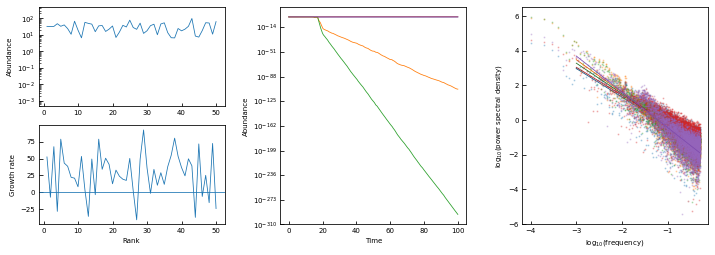

In [83]:
N = 50
size = 30.0

steadystate = np.full([N, 1], size)

params = make_params(steadystate, interaction=0.16)

ts = Timeseries(params, T=100,
                    noise_implementation = NOISE.LANGEVIN_LINEAR).timeseries

plot_timeseries_parameters(ts, params)

# Rescaled model

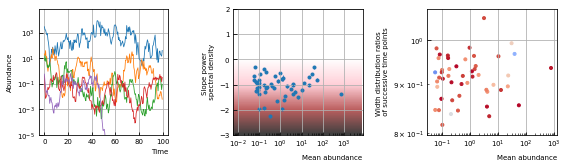

In [74]:
# rescale afterwards

N = 50

steadystate = np.ones([N,1])

params = make_params(steadystate, noise=1.3)

ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                    dt = 0.01, tskip=49, T=100.0, seed=int(time.time())).timeseries

for i in range(N):
    ts['species_%d' % (i+1)] *= experimental_abundance[i] * 1000 / ts['species_%d' % (i+1)].mean()

PlotTimeseriesComparison([ts], composition=['ts', 'nc', 'disdx'], vertical=False) 
#plt.savefig('figures/interaction_rescaled_model2.png')
plt.show()

CVT test: number of timepoints: 200, number of species: 50


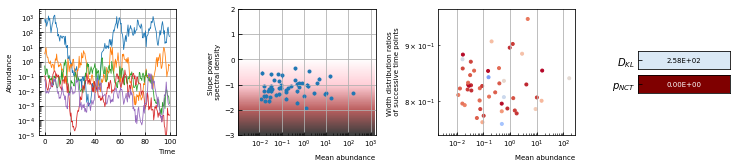

In [75]:
# rescale beforehand

N = 50

steadystate = (experimental_abundance[:N] * 1000).reshape([N, 1])

params = make_params(steadystate, selfint=1/steadystate, noise=1.2) #{}

ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                    dt = 0.01, tskip=49, T=100.0, seed=int(time.time())).timeseries

PlotTimeseriesComparison([ts], composition=['ts', 'nc', 'disdx', 'nn'], 
                        vertical=False)
# plt.savefig('figures/interaction_rescaled_model.png')
plt.show()

CVT test: number of timepoints: 200, number of species: 50


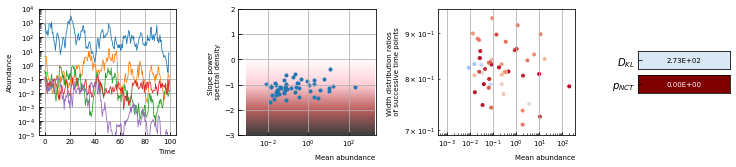

In [25]:
# rescale beforehand

N = 50

steadystate = (experimental_abundance[:N] * 1000).reshape([N, 1])

params = make_params(steadystate, selfint=1/steadystate, noise=1.2) #{}

ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                    dt = 0.01, tskip=49, T=100.0, seed=int(time.time())).timeseries

PlotTimeseriesComparison([ts], composition=['ts', 'nc', 'disdx', 'nn'], 
                        vertical=False)
# plt.savefig('figures/interaction_rescaled_model.png')
plt.show()

CVT test: number of timepoints: 200, number of species: 50


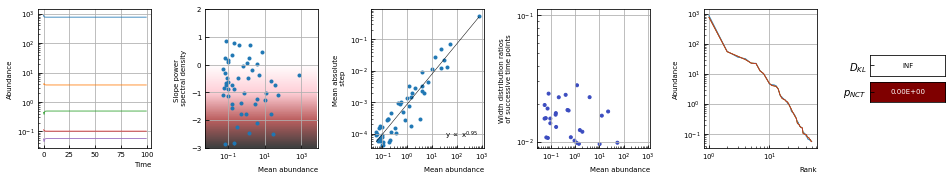

In [84]:
new = True

if new:
    N = 50

    steadystate = (experimental_abundance[:N]*float(1e3)).reshape([N, 1])
    
    params = make_params(steadystate, interaction=0.02, 
                        selfint = 5/steadystate, noise=0)
    
    ts = Timeseries(params, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                        dt = 0.01, tskip=49, T=100.0, seed=int(time.time())).timeseries

fig = plt.figure(figsize=(40/2.54,7/2.54), tight_layout=True) #poster

PlotTimeseriesComparison([ts], composition=['ts', 'nc', 'dx', 'disdx', 'ra', 'nn'], 
                         vertical=False, fig=fig)

#plt.savefig('figures/interaction_rescaled-poster2.pdf')
plt.show()

# Slopes for sqrt and linear noise combinations

In [4]:
# stool A
f = '../../Data/Faust/25_timeseries/25_timeseries.txt'
    # '../../Data/Faust/28_timeseries/28_timeseries.txt'

x = np.loadtxt(f).T #pd.read_csv(f, na_values='NAN', delimiter='\t', header=None)

x = x[150:,:] # do not consider the traveling

experimental_abundance = np.sort(x[0,:])[::-1]

experimental_noise_color = noise_slope(x.T)

{'noise_sqrt': 0, 'noise_ct': 0, 'noise_lin': 0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


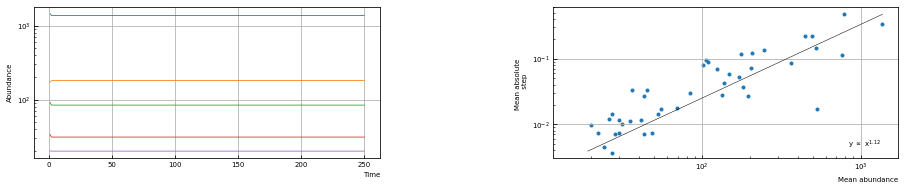

{'noise_sqrt': 0.01, 'noise_ct': 0, 'noise_lin': 0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


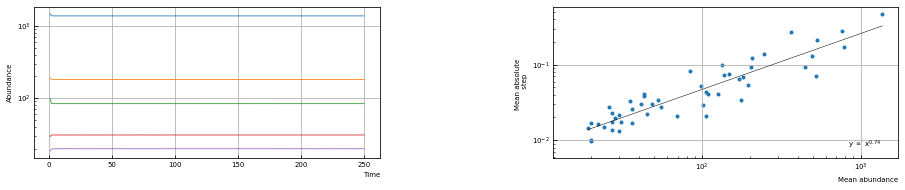

{'noise_sqrt': 0.1, 'noise_ct': 0, 'noise_lin': 0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


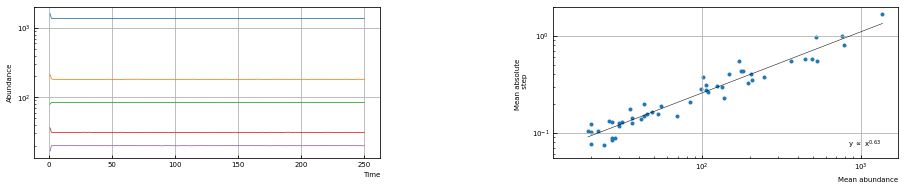

{'noise_sqrt': 0.5, 'noise_ct': 0, 'noise_lin': 0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


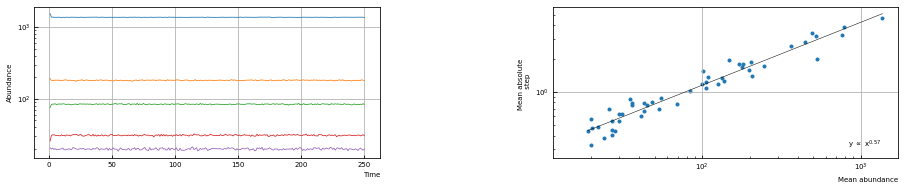

{'noise_sqrt': 1.0, 'noise_ct': 0, 'noise_lin': 0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


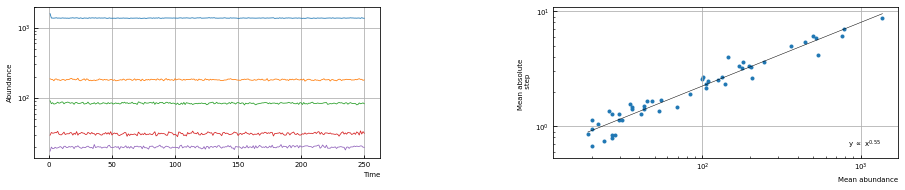

{'noise_sqrt': 0, 'noise_ct': 0, 'noise_lin': 0.01, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


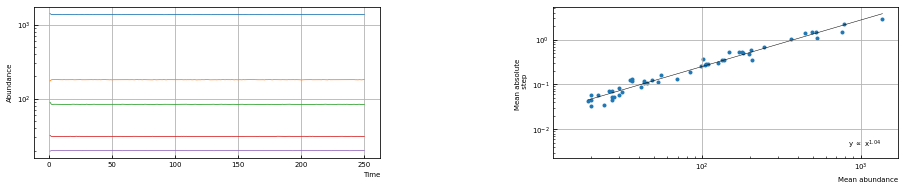

{'noise_sqrt': 0.01, 'noise_ct': 0, 'noise_lin': 0.01, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


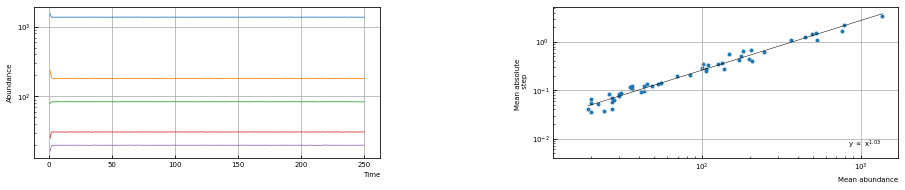

{'noise_sqrt': 0.1, 'noise_ct': 0, 'noise_lin': 0.01, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


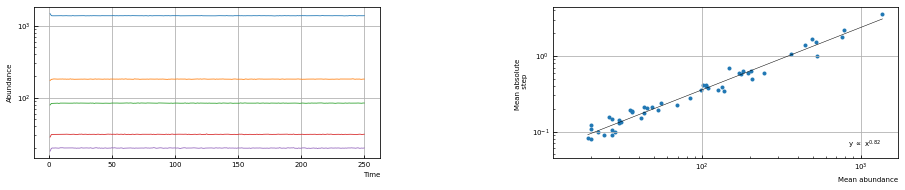

{'noise_sqrt': 0.5, 'noise_ct': 0, 'noise_lin': 0.01, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


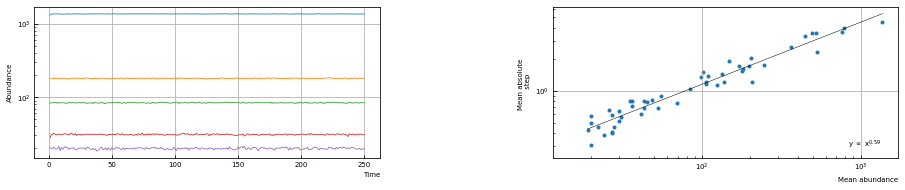

{'noise_sqrt': 1.0, 'noise_ct': 0, 'noise_lin': 0.01, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


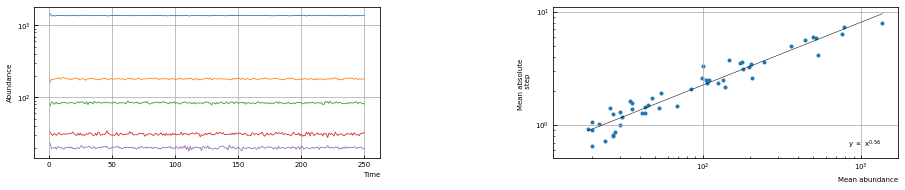

{'noise_sqrt': 0, 'noise_ct': 0, 'noise_lin': 0.1, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


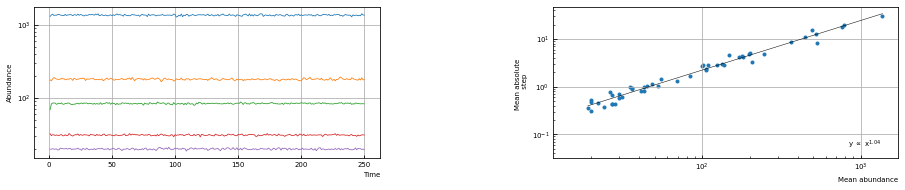

{'noise_sqrt': 0.01, 'noise_ct': 0, 'noise_lin': 0.1, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


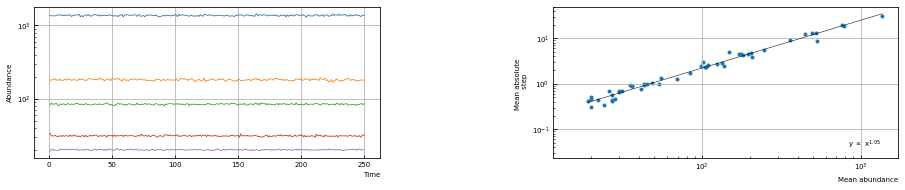

{'noise_sqrt': 0.1, 'noise_ct': 0, 'noise_lin': 0.1, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


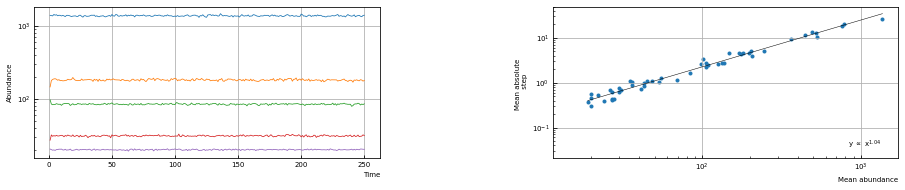

{'noise_sqrt': 0.5, 'noise_ct': 0, 'noise_lin': 0.1, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


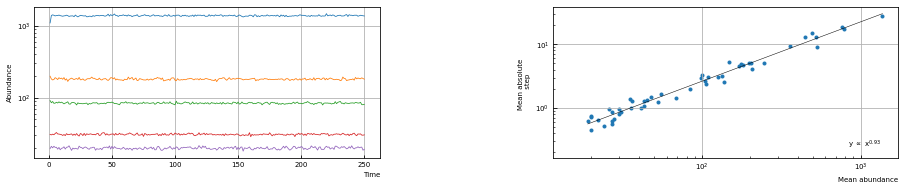

{'noise_sqrt': 1.0, 'noise_ct': 0, 'noise_lin': 0.1, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


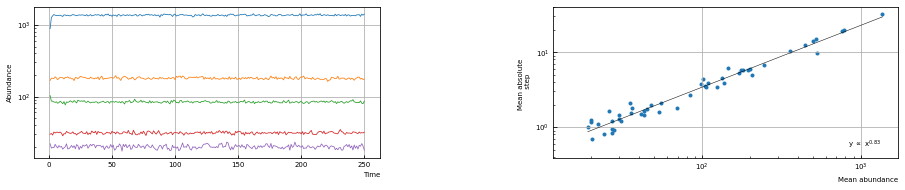

{'noise_sqrt': 0, 'noise_ct': 0, 'noise_lin': 0.5, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


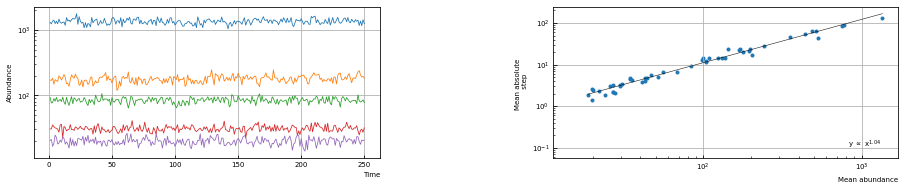

{'noise_sqrt': 0.01, 'noise_ct': 0, 'noise_lin': 0.5, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


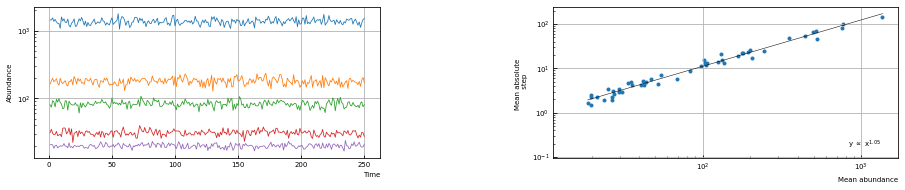

{'noise_sqrt': 0.1, 'noise_ct': 0, 'noise_lin': 0.5, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


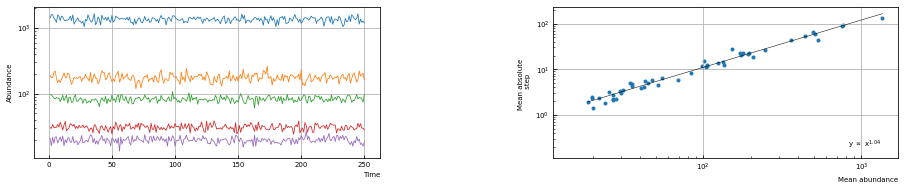

{'noise_sqrt': 0.5, 'noise_ct': 0, 'noise_lin': 0.5, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


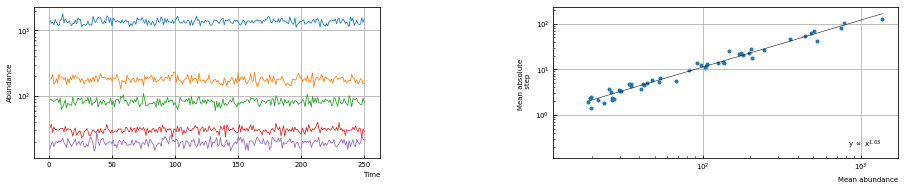

{'noise_sqrt': 1.0, 'noise_ct': 0, 'noise_lin': 0.5, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


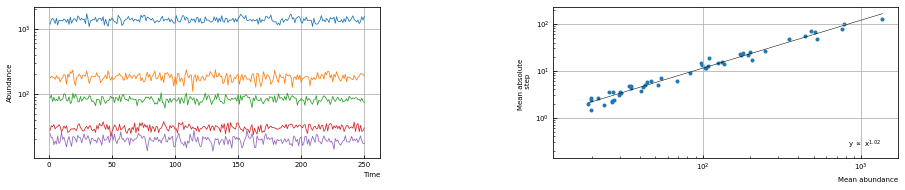

{'noise_sqrt': 0, 'noise_ct': 0, 'noise_lin': 1.0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


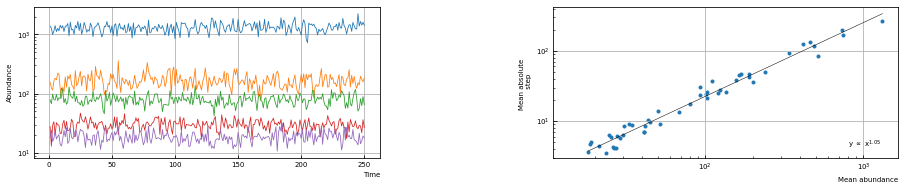

{'noise_sqrt': 0.01, 'noise_ct': 0, 'noise_lin': 1.0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


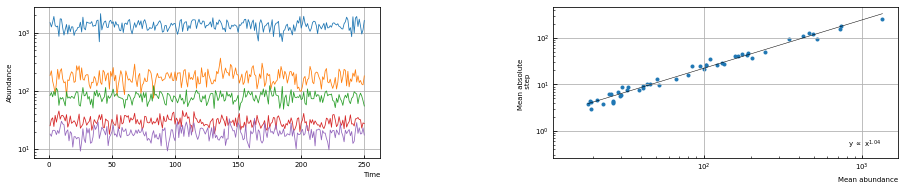

{'noise_sqrt': 0.1, 'noise_ct': 0, 'noise_lin': 1.0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


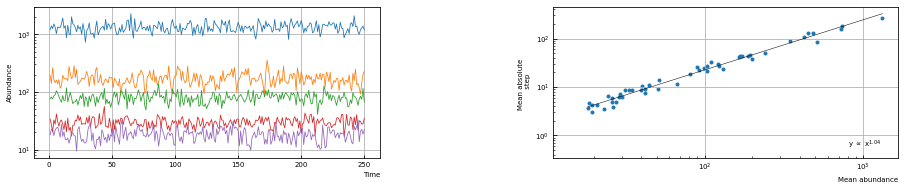

{'noise_sqrt': 0.5, 'noise_ct': 0, 'noise_lin': 1.0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


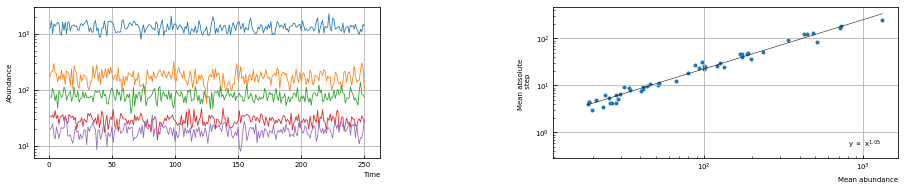

{'noise_sqrt': 1.0, 'noise_ct': 0, 'noise_lin': 1.0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_LINEAR_SQRT: 9>}


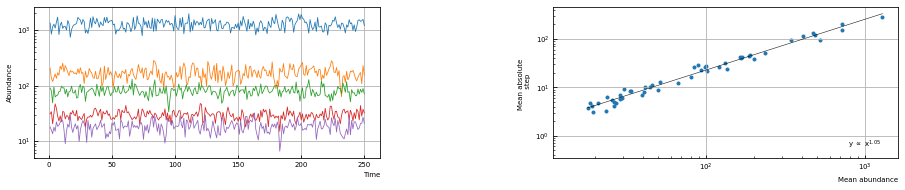

{'noise_sqrt': 0, 'noise_ct': 0, 'noise_lin': 0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_CONSTANT: 1>}


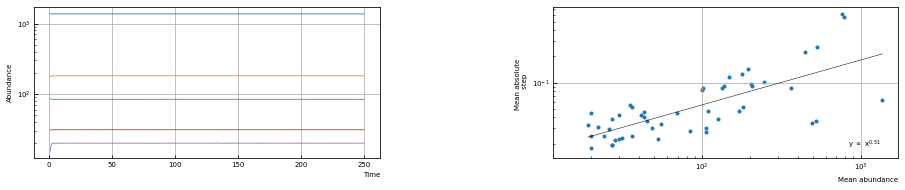

{'noise_sqrt': 0, 'noise_ct': 0.01, 'noise_lin': 0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_CONSTANT: 1>}


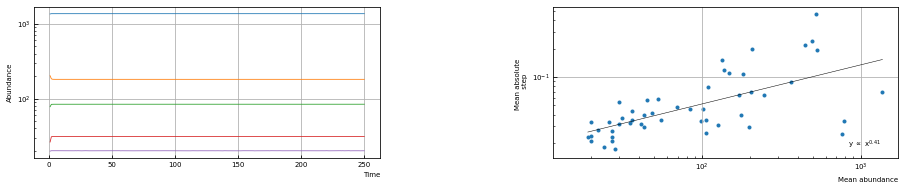

{'noise_sqrt': 0, 'noise_ct': 0.1, 'noise_lin': 0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_CONSTANT: 1>}


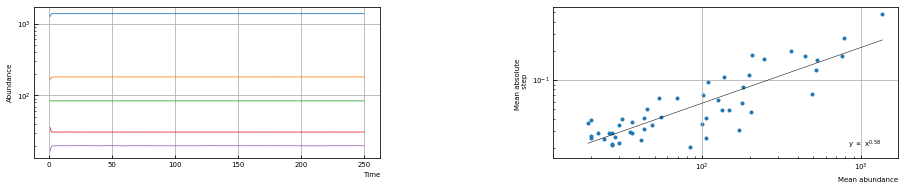

{'noise_sqrt': 0, 'noise_ct': 0.5, 'noise_lin': 0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_CONSTANT: 1>}


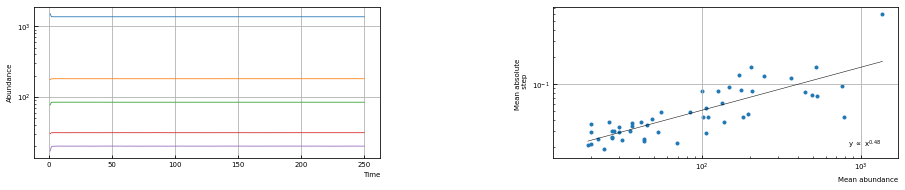

{'noise_sqrt': 0, 'noise_ct': 1.0, 'noise_lin': 0, 'interaction': 0.05, 'implementation': <NOISE.LANGEVIN_CONSTANT: 1>}


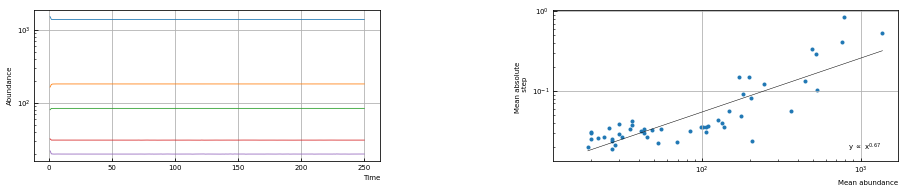

In [30]:
repeats = 10

interactions = [0.05] #0.04] #[0, 0.01, 0.02, 0.05]
noises_init = [0, 0.01, 0.1, 0.5, 1.0]
implementations = [NOISE.LANGEVIN_LINEAR_SQRT, NOISE.LANGEVIN_CONSTANT]

df_slopes = pd.DataFrame(columns = ['interaction', 'implementation'] + ['ts_%d' % i for i in range(repeats)])
df_KL = pd.DataFrame(columns = ['interaction', 'implementation'] + ['ts_%d' % i for i in range(repeats)])
df_NCT = pd.DataFrame(columns = ['interaction', 'implementation'] + ['ts_%d' % i for i in range(repeats)])

N = 50

def one_timeseries(implementation, noise_ct, noise_lin, noise_sqrt):
    def find_ss_selfint(x):
        amplitude = 2.10E+00 
        x0 = 2.87E+00
        k = 1.14E+00
        offset = -1.77E+00

        return 10**( -1/x0 * np.log(amplitude/(x-offset) - 1) + k)

    params = {}

    steadystate = (experimental_abundance[:N]).reshape([N, 1])

    selfints = find_ss_selfint(experimental_noise_color['slope_linear'].values[:N]) / steadystate.flatten()

    params = make_params(steadystate, selfint=selfints, connectivity=0.1)
        
    params['noise_linear'] = noise_lin
    params['noise_sqrt'] = noise_sqrt
    params['noise'] = noise_ct
    
    ts = Timeseries(params, noise_implementation = implementation,
        dt = 0.01, tskip=19, T=50.0, seed=int(time.time())).timeseries
    ts.time = np.arange(1, len(ts)+1)
        
    return ts


for implementation in implementations:
    
    if implementation == NOISE.LANGEVIN_CONSTANT:
        noises_ct = noises_init[:]
        noises_lin = [0]
        noises_sqrt = [0]
    elif implementation == NOISE.LANGEVIN_LINEAR_SQRT:
        noises_ct = [0]
        noises_lin = noises_init[:]
        noises_sqrt = noises_init[:]
        
    for interaction in interactions:
        for noise_ct in noises_ct:
            for noise_lin in noises_lin:
                for noise_sqrt in noises_sqrt:                    
                    slopes = {'interaction':interaction, 'noise_lin':noise_lin, 
                              'implementation':implementation,
                         'noise_sqrt':noise_sqrt, 'noise_ct' : noise_ct}
                    #KL = {'interaction':interaction, 'noise_lin':noise_lin, 
                    #          'implementation':implementation,
                    #     'noise_sqrt':noise_sqrt, 'noise_ct' : noise_ct}
                    #NCT = {'interaction':interaction, 'noise_lin':noise_lin, 
                    #          'implementation':implementation,
                    #     'noise_sqrt':noise_sqrt, 'noise_ct' : noise_ct}
                
                    for i in range(repeats):
                        ts = one_timeseries(implementation, noise_ct, noise_lin, noise_sqrt)
                                                
                        if i == 0:
                            print(slopes)
                            fig = plt.figure(figsize=(15,3))
                            PlotTimeseriesComparison([ts], composition=['ts', 'dx'], vertical=False, fig=fig)
                            plt.show()

                        mean = ts.mean()
                        mean.drop('time', inplace=True)

                        dx = (ts.values[1:, 1:] - ts.values[:-1, 1:])  # / x.values[:-1, 1:];
                        dx[~np.isfinite(dx)] = np.nan
                        mean_dx = np.nanmean(abs(dx), axis=0)
                        
                        x = np.log10(mean[~np.isnan(mean_dx)])
                        y = np.log10(mean_dx[~np.isnan(mean_dx)])
                        
                        if len(x) > 0:
                            p_lin = np.polyfit(x, y, deg=1, cov=False)
                            slopes['ts_%d' % i] = p_lin[0]
                        else:
                            slopes['ts_%d' % i] = np.nan
                        
                        #KL[i] = KullbackLeibler(ts)
                        #norm_ts = ts.values[:, 1:].copy()
                        #norm_ts /= norm_ts.sum(axis=1, keepdims=True)
                        #NCT[i] = neutral_covariance_test(norm_ts, ntests=500, method='Kolmogorov', seed=56)

                    df_slopes = df_slopes.append(slopes, ignore_index=True)
                    #df_KL = df_slopes.append(KL, ignore_index=True)
                    #df_NCT = df_slopes.append(NCT, ignore_index=True)

df_slopes.to_csv('2020.csv') #'extra18_slopes_scale_strongint.csv')
#df_KL.to_csv('extra17_KLd.csv')
#df_NCT.to_csv('extra17_NCTd.csv')

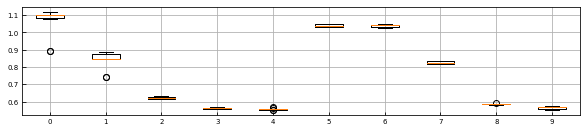

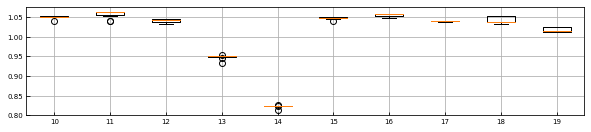

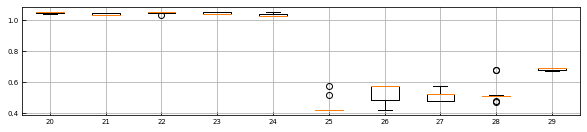

In [37]:
df_slopes = pd.read_csv('2020_005.csv', index_col=0, na_values='NAN')

for i in range(3):
    labels = [j for j in range(10*i, 10*(i+1))]
    s = df_slopes.iloc[range(10*i, 10*(i+1))].loc[:, ['ts_%d' % i for i in range(10)]]
    
    fig = plt.figure(figsize=(10,2))
    ax = fig.add_subplot(111)
    ax.boxplot(s)
    ax.set_xticklabels(labels)
    ax.grid()
    
    plt.show()
    

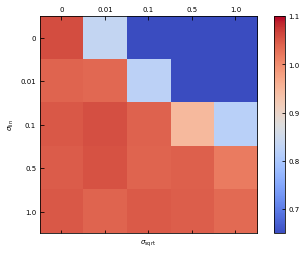

In [32]:
df_slopes2 = pd.read_csv('2020.csv', index_col=0, na_values='NAN')
df_slopes2 = df_slopes2[df_slopes2.implementation == NOISE.LANGEVIN_LINEAR_SQRT]

Nts = 10

df_slopes2['slope'] = df_slopes2.loc[:,['ts_%d' % i for i in range(Nts)]].mean(axis=1)
df_slopes2['slope_std'] = df_slopes2.loc[:,['ts_%d' % i for i in range(Nts)]].std(axis=1)
df_slopes2.drop(['ts_%d'%i for i in range(Nts)], axis=1, inplace=True)

slope = df_slopes2.drop(['implementation', 'interaction', 'slope_std', 'noise_ct'], axis=1)
std_slope = df_slopes2.drop(['implementation', 'interaction', 'slope', 'noise_ct'], axis=1)

slope = slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')
std_slope = std_slope.groupby(['noise_lin', 'noise_sqrt']).agg('mean')

slope = slope.unstack() #.iloc[:4, :4]
std_slope = std_slope.unstack().iloc[:4, :4]

val = slope.values

fig = plt.figure()
ax = fig.add_subplot(111)

mat = ax.matshow(val, cmap='coolwarm', vmin=0.65, vmax=1.1)
ax.set_xlabel(r'$\sigma_\mathregular{sqrt}$')
ax.set_ylabel(r'$\sigma_\mathregular{lin}$')
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])

ax.set_xticklabels([0, 0.01, 0.1, 0.5, 1.0])
ax.set_yticklabels([0, 0.01, 0.1, 0.5, 1.0])

fig.colorbar(mat)

plt.show()